In [89]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [6]:
tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,22.519333,22.614000,21.684000,22.186666,22.186666,94534500
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000


In [18]:
dow_30_tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO',
                 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
                 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 
                 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V',
                 'WBA', 'WMT', 'DIS', 'DOW']

In [34]:
def add_ticker_name(df, ticker):
    df.set_axis([ticker + '_' + col for col in list(df.columns)], axis=1, inplace=True)
    return df

On va commencer par prendre un df avec 2 stock, on va calculer les indic (mva, rsi etc) et tout les jours en acheter un et short l'autre

In [76]:
df = yf.download('AXP', start = '2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [120]:
### Functions to get classical Technical Trading indicators

# Simple Moving Average 
def SMA(data, ndays): 
    data['SMA_'+str(ndays)] = pd.Series(data['Close'].rolling(ndays).mean())
    return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    data['EWMA_' + str(ndays)] = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean())
    return data

def rsi(df, periods = 14):
    
    close = df.Close
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    df['rsi_' + str(periods)] = rsi
    return df

def gain(x):
    return ((x > 0) * x).sum()
def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def mfi(df, n=14):
    typical_price = (df.High + df.Low + df.Close)/3
    money_flow = typical_price * df.Volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    
    df['mfi_' + str(n)] = mfi
    
    return df
    
    # Returns ATR values
def atr(df, n=14):
    tr = np.amax(np.vstack(((df.High - df.Low).to_numpy(), (abs(df.High - df.Close)).to_numpy(), (abs(df.Low - df.Close)).to_numpy())).T, axis=1)    
    atr = pd.Series(tr).rolling(n).mean().to_numpy()
    df['atr_' + str(n)] = atr
    return df

def ForceIndex(data, ndays = 1): 
    data['ForceIndex_' + str(ndays)] = pd.Series(data['Close'].diff(ndays) * data['Volume']) 
    return data

def EMV(data, ndays = 14): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data['EMV_MA_' + str(ndays)] = EMV_MA
    return data 

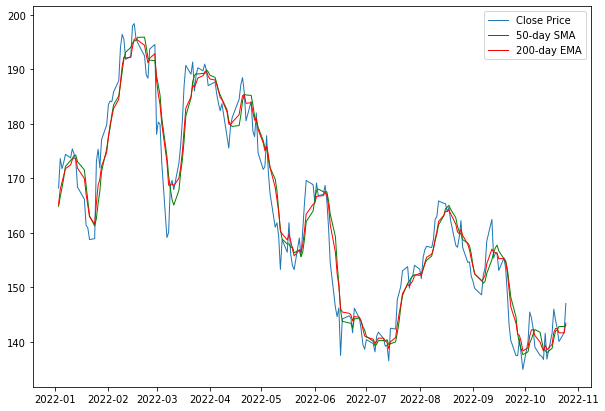

In [96]:
small_df = df[df.index >= '2022-01-01']

plt.figure(figsize=(10,7))

# Plot close price and moving averages
plt.plot(small_df['Close'],lw=1, label='Close Price')
plt.plot(small_df['SMA_5'],'g',lw=1, label='50-day SMA')
plt.plot(small_df['EWMA_5'],'r', lw=1, label='200-day EMA')

plt.legend()
plt.show()

In [153]:
df.head().shape

(5, 14)

In [33]:
df = add_ticker_name(df, 'AXP')


,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume
Date,,,,,,
2014-12-31,94.650002,94.750000,93.000000,93.040001,82.503960,2306200
2015-01-02,93.169998,93.940002,92.139999,93.019997,82.486229,2437500
2015-01-05,92.459999,92.779999,90.320000,90.559998,80.304817,3469600
2015-01-06,90.790001,90.900002,87.940002,88.629997,78.593353,4800300
2015-01-07,91.010002,91.010002,89.529999,90.300003,80.309822,5665200
...,...,...,...,...,...,...
2022-10-19,145.429993,147.070007,142.600006,143.970001,143.970001,2803900
2022-10-20,144.000000,147.320007,142.149994,142.419998,142.419998,4319300
2022-10-21,140.990005,141.320007,132.210007,140.039993,140.039993,11745300


In [20]:
df = 
for tic in dow_30_tickers[1:]:
    print(tic)
    test = yf.download(tic, 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)


AXP
AMGN
AAPL
BA
CAT
CSCO
CVX
GS
HD
HON
IBM
INTC
JNJ
KO
JPM
MCD
MMM
MRK
MSFT
NKE
PG
TRV
UNH
CRM
VZ
V
WBA
WMT
DIS
DOW


In [22]:
len(dow_30_tickers)

30